In [19]:
import os
import random
%load_ext autotime

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [2, 2]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper_triangle import TriangleLabeledDataset,image_names
from helper import collate_fn, draw_box

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

%load_ext autoreload
%autoreload 2

# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = 'data'
annotation_csv = 'data/annotation.csv'

labeled_scene_index = np.arange(106, 134)
image_names

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


['CAM_FRONT.jpeg',
 'CAM_FRONT_LEFT.jpeg',
 'CAM_BACK_LEFT.jpeg',
 'CAM_BACK.jpeg',
 'CAM_BACK_RIGHT.jpeg',
 'CAM_FRONT_RIGHT.jpeg']

In [8]:
transform = torchvision.transforms.ToTensor()
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
labeled_trainset = TriangleLabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True,
                                camera = 'CAM_FRONT.jpeg'
                                 )

In [15]:
trainloader = torch.utils.data.DataLoader(labeled_trainset , batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

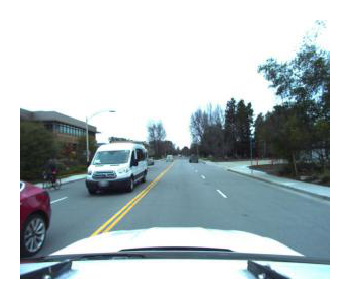

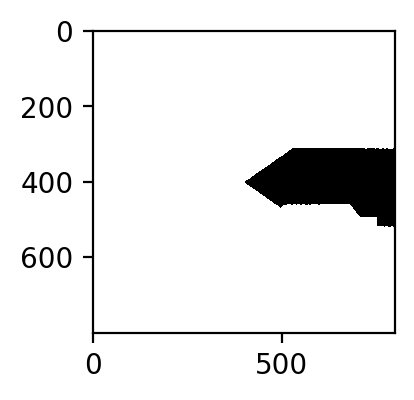

In [16]:
sample, target, road_image, extra = iter(trainloader).next()
plt.imshow(sample[0].numpy().transpose(1, 2, 0))
plt.axis('off');
fig, ax = plt.subplots()

ax.imshow(road_image[0], cmap='binary');

In [56]:
#TO TRAIN
# means = []
# stds = []
# count_imgs = 0
# for samples, target, road_image, extra  in trainloader:
#     for sample in samples:
#         means.append(torch.mean(sample,axis = [1,2]).numpy())
#         stds.append(torch.std(sample,axis = [1,2]).numpy())
#         count_imgs = count_imgs+1
#     if count_imgs > 20000:
#         break
        
# means = np.array(means).mean(axis = 0)
# stds = np.array(stds).mean(axis = 0)
means = [0.6394939, 0.6755114, 0.7049375]
stds = [0.31936955, 0.3117349 , 0.2953726 ]

time: 1min 10s


time: 1.22 ms


tensor([[[-1.8305, -1.8673, -1.9655,  ...,  1.1288,  1.1288,  1.1288],
         [-1.9532, -1.7077, -1.5849,  ...,  1.1288,  1.1288,  1.1288],
         [-1.6708, -1.1428, -0.8358,  ...,  1.1288,  1.1288,  1.1288],
         ...,
         [-0.7376, -0.7376, -0.7376,  ...,  1.0306,  0.9692,  0.9692],
         [-0.7745, -0.7745, -0.7867,  ...,  1.0551,  0.9323,  0.9323],
         [-0.8850, -0.8727, -0.8481,  ...,  1.0797,  0.9323,  0.9323]],

        [[-1.9405, -2.0160, -2.1040,  ...,  1.0409,  1.0409,  1.0409],
         [-2.0663, -1.8147, -1.6889,  ...,  1.0409,  1.0409,  1.0409],
         [-1.7392, -1.1983, -0.8712,  ...,  1.0409,  1.0409,  1.0409],
         ...,
         [-0.7328, -0.7328, -0.7328,  ...,  1.0032,  1.0283,  1.0283],
         [-0.7580, -0.7832, -0.7957,  ...,  1.0032,  1.0283,  1.0283],
         [-0.8964, -0.8712, -0.8461,  ...,  1.0032,  1.0283,  1.0283]],

        [[-1.7626, -1.8555, -1.9883,  ...,  0.9989,  0.9989,  0.9989],
         [-1.8954, -1.6564, -1.5502,  ...,  0

time: 16 ms
